# Rasgos no basados en modelos

In [1]:
from copy import deepcopy
from itertools import chain
import math
import os

import nltk
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

from config import DATA_PATH, VISUALIZATIONS_PATH, MODELS_PATH
from utilities import plot_stats, save_dataframe, list_words

In [5]:
INDEX = os.path.join(MODELS_PATH, "index")

X_train_index = (
    pd
    .read_csv(os.path.join(INDEX, f"X_train_index.csv"), header=None, index_col=0)
    .index
)

In [12]:
FOLDER = os.path.join(VISUALIZATIONS_PATH, "stats")
os.makedirs(FOLDER, exist_ok=True)

data_path = os.path.join(DATA_PATH, "session_speech.csv")

data = pd.read_csv(data_path, converters={"speech_lemma_pos": eval})

data = (
    data[(data.speech.notna()) & (~data.vote.isin(["abstención", "ausente"]))]
    .reset_index(drop=True)
    .assign(
        speech_lemma_pos=lambda x: x.speech_lemma_pos.apply(
            lambda z: " ".join(["_".join(i) for i in z])
        )
    )
    .iloc[X_train_index]
)
data.columns, data.shape

(Index(['name', 'vote', 'senator', 'province', 'party', 'party_family',
        'speaker', 'speech', 'speech_preprocessed', 'speech_lemmas',
        'speech_pos', 'speech_lemma_pos', 'speech_preprocessed_count',
        'speech_preprocessed_count_unique', 'speech_lemmas_count',
        'speech_lemmas_count_unique', 'speech_pos_count',
        'speech_pos_count_unique', 'speech_lemma_pos_count_unique'],
       dtype='object'),
 (159, 19))

In [14]:
data.shape

(159, 19)

In [15]:
data.head(2)

,name,vote,senator,province,party,party_family,speaker,speech,speech_preprocessed,speech_lemmas,speech_pos,speech_lemma_pos,speech_preprocessed_count,speech_preprocessed_count_unique,speech_lemmas_count,speech_lemmas_count_unique,speech_pos_count,speech_pos_count_unique,speech_lemma_pos_count_unique
40,Silvia Del Rosario Giacoppo,negativo,GIACOPPO SILVIA DEL ROSARIO,JUJUY,FRENTE JUJEÑO CAMBIEMOS,Juntos por el cambio,Giacoppo,… y toma al NEA y al NOA como un mapa celeste ...,… y toma al nea y al noa como un mapa celeste ...,y tomar al nea y al noa como un mapa celeste e...,CCONJ VERB ADP PROPN CCONJ ADP PROPN SCONJ DET...,y_CCONJ tomar_VERB al_ADP nea_PROPN y_CCONJ al...,185,101,184,91,184,10,92
18,Julio César Cleto Cobos,negativo,COBOS JULIO CÉSAR CLETO,MENDOZA,ALIANZA CAMBIEMOS,Juntos por el cambio,Cobos,"Gracias, señora presidenta. La verdad es que l...",gracias señora presidenta la verdad es que lle...,gracia señora presidenta la verdad ser que lle...,NOUN NOUN NOUN DET NOUN VERB SCONJ VERB ADJ NO...,gracia_NOUN señora_NOUN presidenta_NOUN la_DET...,449,226,446,196,446,10,196


In [16]:
data.vote.value_counts()

vote
positivo    89
negativo    70
Name: count, dtype: int64

In [17]:
data.speech.isna().sum()

0

## Diferencia de frecuencias

Diferencia en la frecuencia absoluta de uso de palabras:

$$
y_{kw}^{(P)}-y_{kw}^{(N)}
$$

Donde k refier e al tópico, w a la palabras y P y N a los senadores que han votado positiva y negativamente, de forma respectiva.
Al considerar en este trabajo un único tópico (el aborto y su legalización), simplificamos, en este aparetado y en los siguientes:

$$
y_{w}^{(P)}-y_{w}^{(N)}
$$

El rpblema con esyte enfoque es que se ve supeditado a aquel conjunto de senadores que haya hablado más.

In [19]:
vectorizer = CountVectorizer(lowercase=True)
X = vectorizer.fit_transform(data.speech_lemma_pos)
X = X.toarray()
frequencies = (
    pd
    .DataFrame(
        X, columns=vectorizer.get_feature_names_out(), index=data["vote"]
    )
    .rename_axis("senator_vote", axis=0)
    .reset_index()
    .groupby("senator_vote")
    .sum()
)
frequencies

,a_adp,abajo_adv,abandonada_adj,abandonado_adj,abandonar_verb,abandono_noun,abarcar_verb,abdominal_adj,aber_verb,aberración_noun,...,órgano_noun,óvulo_noun,última_adj,últimamente_adv,último_adj,única_adj,únicamente_adv,único_adj,útero_noun,útil_adj
senator_vote,,,,,,,,,,,,,,,,,,,,,
negativo,512,1,0,0,1,1,2,0,0,1,...,0,1,3,0,7,2,0,5,3,1
positivo,1259,0,1,1,0,0,0,1,1,0,...,4,1,2,1,14,11,1,7,4,0


In [20]:
count_total = frequencies.sum(axis=0).apply(lambda x: math.log(x))
count_difference = frequencies.loc["positivo"]-frequencies.loc["negativo"]
count_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": count_difference,
        "pos": frequencies.loc["positivo"],
        "neg": frequencies.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
count_diff.head()

,word,total,diff,pos,neg
0,a_adp,7.4793,747,1259,512
1,abajo_adv,0.0000,-1,0,1
2,abandonada_adj,0.0000,1,1,0
3,abandonado_adj,0.0000,1,1,0
4,abandonar_verb,0.0000,-1,0,1


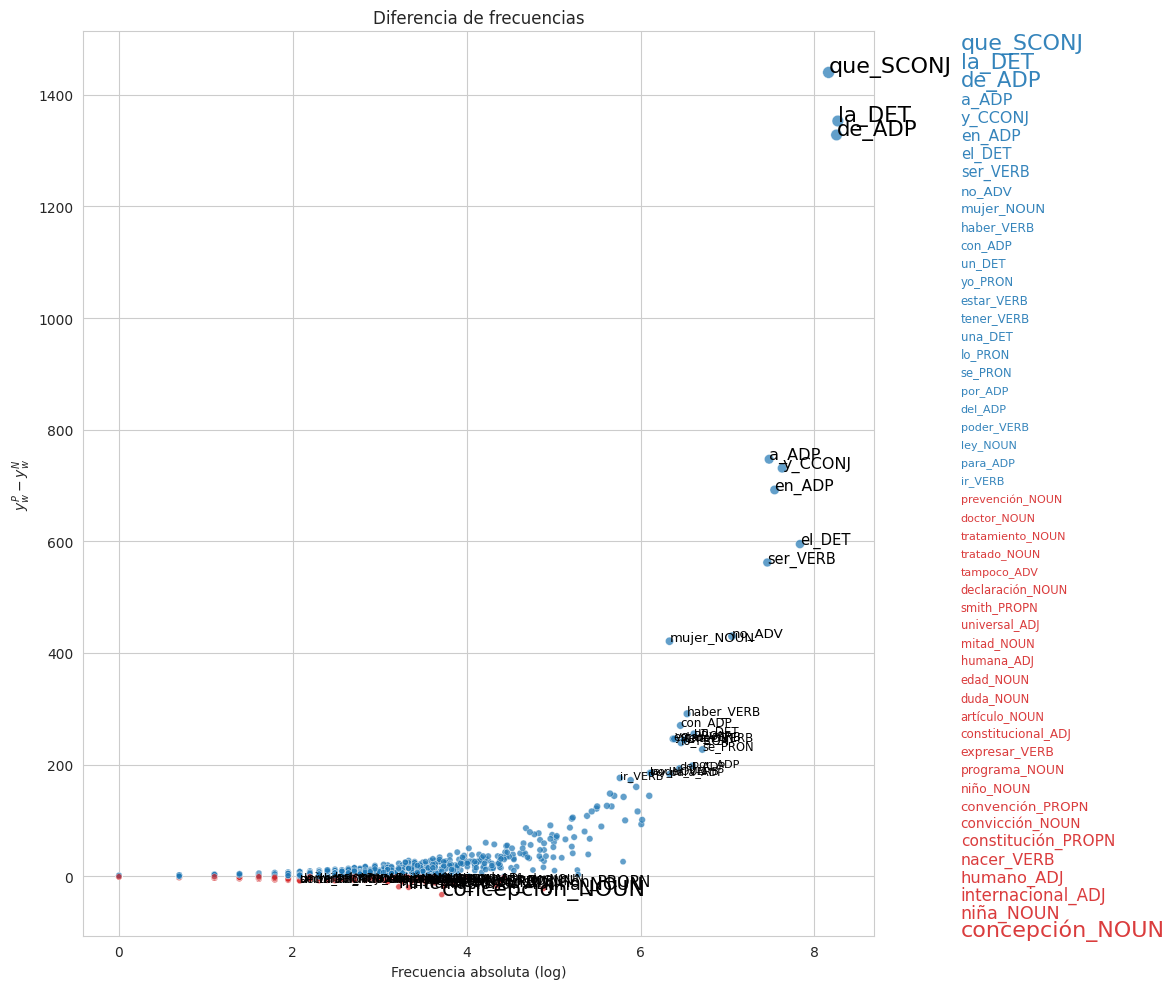

In [21]:
filename = "frecuencias"
save_dataframe(count_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
ax = plot_stats(count_diff, "Diferencia de frecuencias", "$y^{P}_{w}-y^{N}_{w}$", file, nwords=25)

In [22]:
list_words(count_diff)

--- POS
`de', `a', `en', `con', `por', `del', `para' (adp)
`no' (adv)
`y' (cconj)
`la', `el', `un', `una' (det)
`mujer', `ley' (noun)
`yo', `lo', `se' (pron)
`que' (sconj)
`ser', `haber', `estar', `tener', `poder', `ir' (verb)
--- NEG
`universal', `humana', `constitucional', `humano', `internacional' (adj)
`tampoco' (adv)
`prevención', `doctor', `tratamiento', `tratado', `declaración', `mitad', `edad', `duda', `artículo', `programa', `niño', `convicción', `niña', `concepción' (noun)
`smith', `convención', `constitución' (propn)
`expresar', `nacer' (verb)


## Diferencia de proporciones

Se normalizan los vectores de palabras para reflejar las proporciones en lugar de su ocurrencia. La proporción observada se define como:

$$
f_{w}^{(i)} = y_{w}^{(i)} / n^{(i)}
$$

$$
f_{w}^{(P)}-f_{w}^{(N)}
$$

A diferencia del enfoque anterior, este abordaje evita el sesgo partidario basado en el volumen de los discursos.

La limitación aquí es la carencia de validez semántica, que se puede observar en el énfasis otorgado a las palabras de mayor frecuencia. Las palabras que parecen describir mejor los discursos de ambas posturas no son palabras que denoten posiciones políticas realmente sino palabras de alta frecuencia en el uso.

In [23]:
frequencies.sum(axis=1)

senator_vote
negativo    22996
positivo    47222
dtype: int64

In [24]:
proportions = frequencies.div(frequencies.sum(axis=1), axis=0)
proportions_difference = proportions.loc["positivo"]-proportions.loc["negativo"]
proportions_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": proportions_difference,
        "pos": proportions.loc["positivo"],
        "neg": proportions.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
proportions_diff.head()

,word,total,diff,pos,neg
0,a_adp,7.4793,0.004397,0.026661,0.022265
1,abajo_adv,0.0000,-0.000043,0.000000,0.000043
2,abandonada_adj,0.0000,0.000021,0.000021,0.000000
3,abandonado_adj,0.0000,0.000021,0.000021,0.000000
4,abandonar_verb,0.0000,-0.000043,0.000000,0.000043


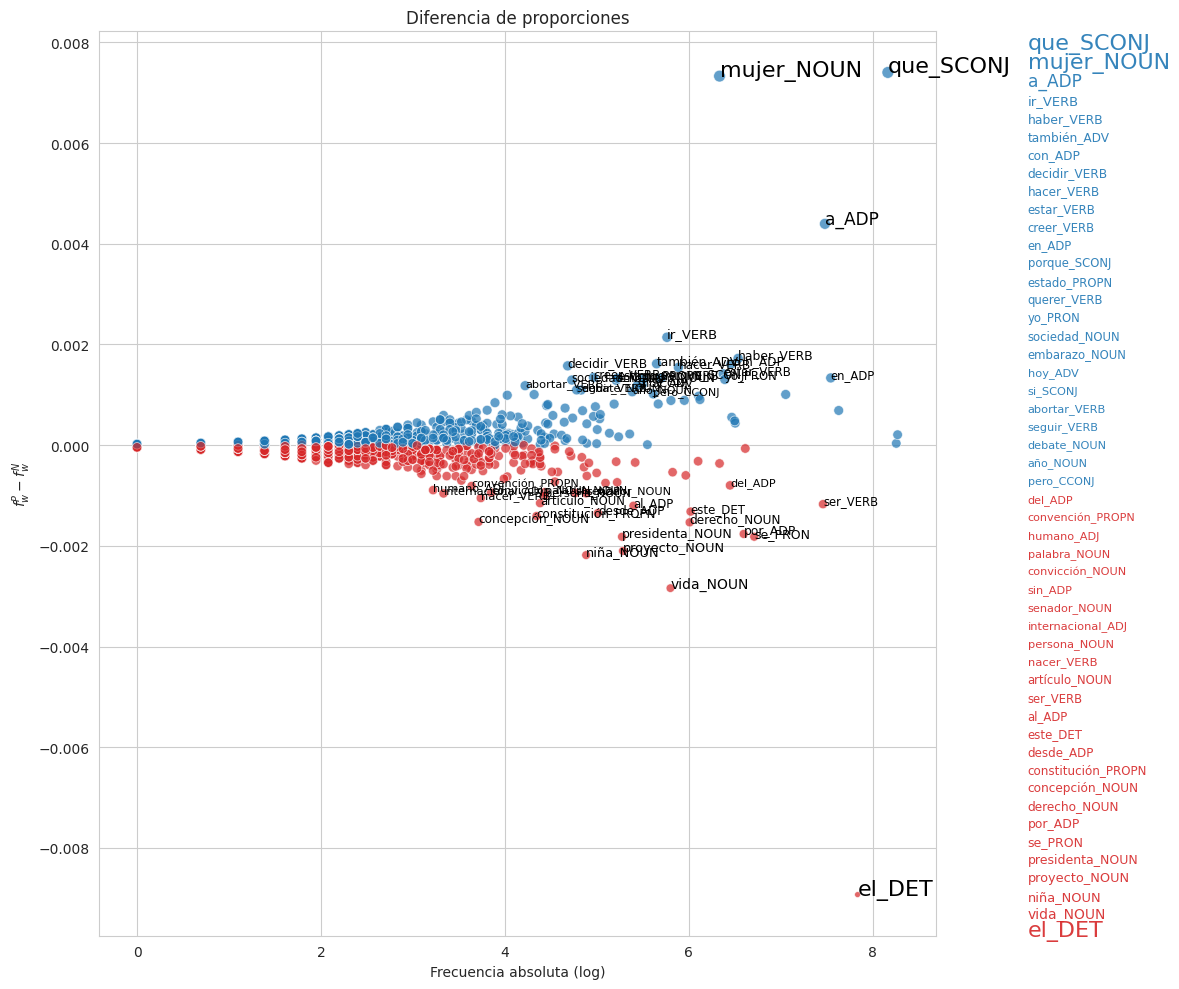

In [25]:
filename = "proporciones"
save_dataframe(proportions_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(proportions_diff, "Diferencia de proporciones", "$f^{P}_{w}-f^{N}_{w}$", file)

In [26]:
list_words(proportions_diff)

--- POS
`a', `con', `en' (adp)
`también', `hoy' (adv)
`pero' (cconj)
`mujer', `sociedad', `embarazo', `debate', `año' (noun)
`yo' (pron)
`estado' (propn)
`que', `porque', `si' (sconj)
`ir', `haber', `decidir', `hacer', `estar', `creer', `querer', `abortar', `seguir' (verb)
--- NEG
`humano', `internacional' (adj)
`del', `sin', `al', `desde', `por' (adp)
`este', `el' (det)
`palabra', `convicción', `senador', `persona', `artículo', `concepción', `derecho', `presidenta', `proyecto', `niña', `vida' (noun)
`se' (pron)
`convención', `constitución' (propn)
`nacer', `ser' (verb)


## Diferencia de proporciones sin stopwords

El problema del énfasis otorgado a las palabras de alta frecuencia suele intentar superarse aislando las palabras de interés y, para esto, se removuen las _stopwords_.

El problema de eliminar las _stopwords_ es que podemos terminar eliminando palabras que son significativas para el problema en cuestión (ej: "ella" en el tópico aquí abordado).

### Stopwrods de NLTK

In [27]:
nltk.download("stopwords")

from nltk.corpus import stopwords

stw = stopwords.words("spanish")
print(stw[:5])

['de', 'la', 'que', 'el', 'en']


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/macarena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
print(f"Cantidad de columnas (lemas+pos) en el dataset: {len(frequencies.columns)}")
words = [item.split("_")[0] for item in frequencies.columns.to_list()]
stop = len(sorted(set(words).intersection(set(stw))))
print(f"Cantidad de lemas stopwords en el dataset: {stop}")
non_stop = len(sorted(set(words).difference(set(stw))))
print(f"Cantidad de lemas no stopwords en el dataset: {non_stop}")

Cantidad de columnas (lemas+pos) en el dataset: 4480
Cantidad de lemas stopwords en el dataset: 76
Cantidad de lemas no stopwords en el dataset: 4306


In [29]:
columns_wo_stw = list()
for item in sorted(frequencies.columns.to_list()):
    word, _ = item.split("_")
    if word in stw:
        continue
    else:
        columns_wo_stw.append(item)
frequencies_wo_stw = frequencies[columns_wo_stw]
frequencies_wo_stw.shape

(2, 4397)

In [30]:
proportions_wo_stw = frequencies_wo_stw.div(frequencies_wo_stw.sum(axis=1), axis=0)
proportions_wo_stw_difference = (
    proportions_wo_stw.loc["positivo",frequencies_wo_stw.columns]-proportions_wo_stw.loc["negativo",frequencies_wo_stw.columns]
)

proportions_wo_stw_diff = (
    pd
    .DataFrame({
        "total": count_total[frequencies_wo_stw.columns],
        "diff": proportions_wo_stw_difference,
        "pos": proportions_wo_stw.loc["positivo"],
        "neg": proportions_wo_stw.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
proportions_wo_stw_diff.head()

,word,total,diff,pos,neg
0,abajo_adv,0.0,-0.000085,0.000000,0.000085
1,abandonada_adj,0.0,0.000042,0.000042,0.000000
2,abandonado_adj,0.0,0.000042,0.000042,0.000000
3,abandonar_verb,0.0,-0.000085,0.000000,0.000085
4,abandono_noun,0.0,-0.000085,0.000000,0.000085


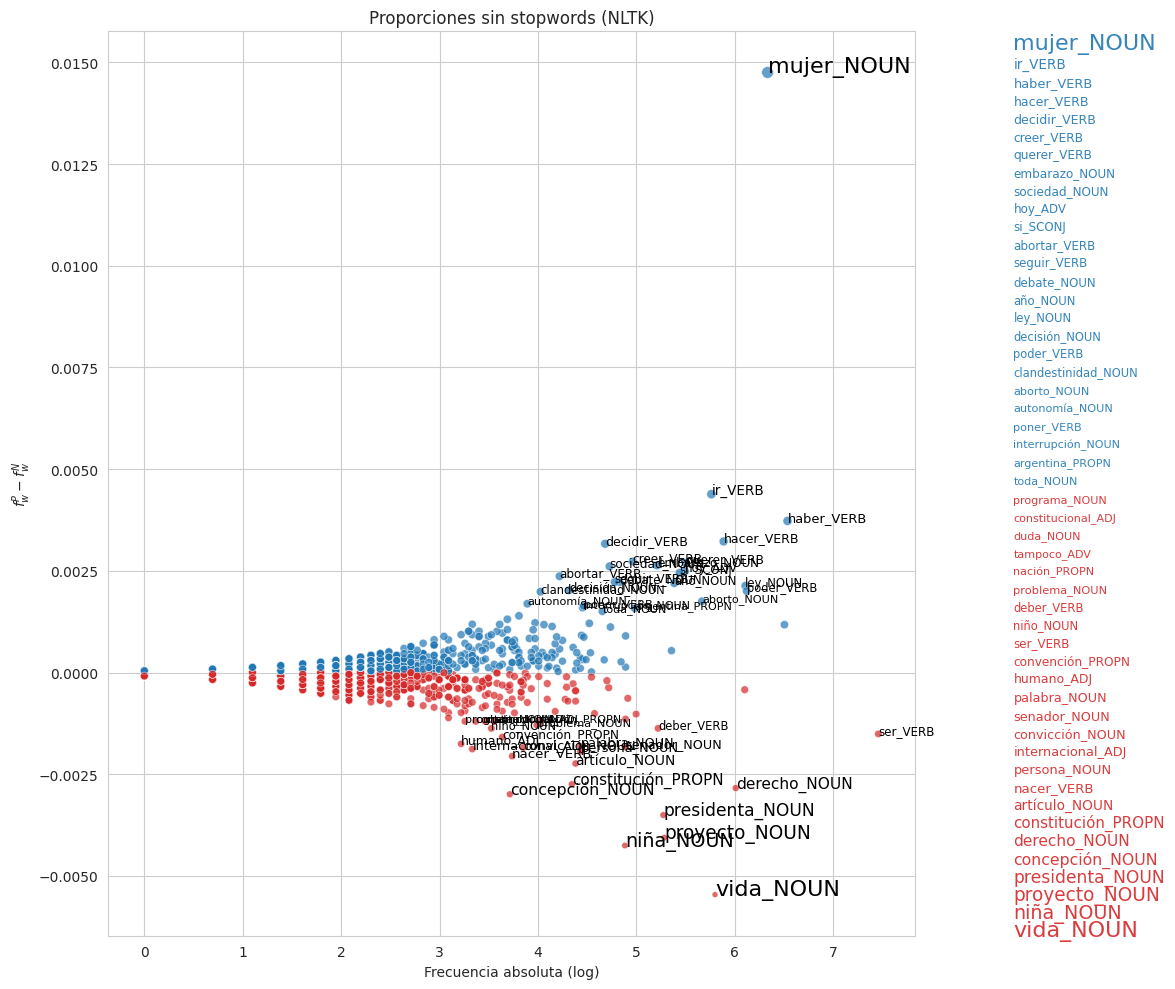

In [31]:
filename = "proporciones_sin_stopwords_nltk"
save_dataframe(proportions_wo_stw_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(
    proportions_wo_stw_diff, "Proporciones sin stopwords (NLTK)", "$f^{P}_{w}-f^{N}_{w}$", file
)

In [32]:
list_words(proportions_wo_stw_diff)

--- POS
`hoy' (adv)
`mujer', `embarazo', `sociedad', `debate', `año', `ley', `decisión', `clandestinidad', `aborto', `autonomía', `interrupción', `toda' (noun)
`argentina' (propn)
`si' (sconj)
`ir', `haber', `hacer', `decidir', `creer', `querer', `abortar', `seguir', `poder', `poner' (verb)
--- NEG
`constitucional', `humano', `internacional' (adj)
`tampoco' (adv)
`programa', `duda', `problema', `niño', `palabra', `senador', `convicción', `persona', `artículo', `derecho', `concepción', `presidenta', `proyecto', `niña', `vida' (noun)
`nación', `convención', `constitución' (propn)
`deber', `ser', `nacer' (verb)


### Stopwords por Ley de Zipf

In [33]:
filename = os.path.join(VISUALIZATIONS_PATH, "zipf_law.csv")
zipf_law = pd.read_csv(filename)
zipf_law.head()

,order,selected_lemma,selected_pos,count,raw,raw_count,log_order,log_count
0,0,la,DET,3903.0,"['las', 'la']","[970.0, 2933.0]",0.000000,8.269501
1,1,de,ADP,3846.0,['de'],[3846.0],0.693147,8.254789
2,2,que,SCONJ,3510.0,['que'],[3510.0],1.098612,8.163371
3,3,el,DET,2525.0,"['el', 'los']","[1596.0, 929.0]",1.386294,7.833996
4,4,y,CCONJ,2057.0,['y'],[2057.0],1.609438,7.629004


In [34]:
zipf_law.shape

(4446, 8)

In [35]:
(
    zipf_law.loc[zipf_law.order<100, ["selected_lemma", "selected_pos"]]
    .apply(lambda x: "_".join(x), axis=1)
    .to_list()
)

['la_DET',
 'de_ADP',
 'que_SCONJ',
 'el_DET',
 'y_CCONJ',
 'en_ADP',
 'a_ADP',
 'ser_VERB',
 'no_ADV',
 'se_PRON',
 'un_DET',
 'por_ADP',
 'haber_VERB',
 'tener_VERB',
 'una_DET',
 'lo_PRON',
 'con_ADP',
 'del_ADP',
 'yo_PRON',
 'estar_VERB',
 'mujer_NOUN',
 'para_ADP',
 'poder_VERB',
 'ley_NOUN',
 'decir_VERB',
 'este_DET',
 'derecho_NOUN',
 'como_SCONJ',
 'su_DET',
 'hacer_VERB',
 'o_CCONJ',
 'esta_DET',
 'vida_NOUN',
 'ir_VERB',
 'porque_SCONJ',
 'aborto_NOUN',
 'también_ADV',
 'pero_CCONJ',
 'más_ADV',
 'querer_VERB',
 'hoy_ADV',
 'si_SCONJ',
 'mi_DET',
 'al_ADP',
 'año_NOUN',
 'salud_NOUN',
 'estado_PROPN',
 'proyecto_NOUN',
 'presidenta_NOUN',
 'todo_NOUN',
 'deber_VERB',
 'embarazo_NOUN',
 'esto_PRON',
 'esa_DET',
 'sobre_ADP',
 'él_PRON',
 'nuestra_DET',
 'ese_DET',
 'desde_ADP',
 'cuando_SCONJ',
 'dar_VERB',
 'todo_ADJ',
 'argentina_PROPN',
 'creer_VERB',
 'eso_PRON',
 'temer_VERB',
 'gracia_NOUN',
 'hablar_VERB',
 'saber_VERB',
 'niña_NOUN',
 'senador_NOUN',
 'nuestro_DET',


In [36]:
zipf_law[zipf_law.order<100].log_order.max()

4.605170185988092

In [37]:
zipf_law[zipf_law.order<100].log_count.max()

8.269500767180615

In [38]:
(zipf_law["count"] / zipf_law["count"].sum())[zipf_law.order<100]

0     0.055495
1     0.054684
2     0.049907
3     0.035902
4     0.029247
        ...   
95    0.001237
96    0.001237
97    0.001223
98    0.001223
99    0.001209
Name: count, Length: 100, dtype: float64

In [39]:
zipf_stw = zipf_law[zipf_law.order<100].apply(
    lambda x: f"{x.selected_lemma}_{x.selected_pos}".lower(), axis=1
).to_list()
zipf_stw[:5]

['la_det', 'de_adp', 'que_sconj', 'el_det', 'y_cconj']

In [40]:
print(f"Cantidad de columnas (palabras) en el dataset: {len(frequencies.columns)}")
stop = len(sorted(set(frequencies.columns).intersection(set(zipf_stw))))
print(f"Cantidad de palabras stopwords en el dataset: {stop}")
non_stop = len(sorted(set(frequencies.columns).difference(set(zipf_stw))))
print(f"Cantidad de palabras no stopwords en el dataset: {non_stop}")

Cantidad de columnas (palabras) en el dataset: 4480
Cantidad de palabras stopwords en el dataset: 100
Cantidad de palabras no stopwords en el dataset: 4380


In [41]:
columns_wo_stw = sorted(set(frequencies.columns).difference(set(zipf_stw)))
frequencies_wo_stw = frequencies[columns_wo_stw]
frequencies_wo_stw.shape

(2, 4380)

In [42]:
proportions_wo_stw = frequencies_wo_stw.div(frequencies_wo_stw.sum(axis=1), axis=0)
proportions_wo_stw_difference = (
    proportions_wo_stw.loc["positivo",frequencies_wo_stw.columns]-proportions_wo_stw.loc["negativo",frequencies_wo_stw.columns]
)
proportions_wo_stw_diff = (
    pd
    .DataFrame({
        "total": count_total[frequencies_wo_stw.columns],
        "diff": proportions_wo_stw_difference,
        "pos": proportions_wo_stw.loc["positivo"],
        "neg": proportions_wo_stw.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
proportions_wo_stw_diff.head()

,word,total,diff,pos,neg
0,abajo_adv,0.0,-0.000117,0.000000,0.000117
1,abandonada_adj,0.0,0.000062,0.000062,0.000000
2,abandonado_adj,0.0,0.000062,0.000062,0.000000
3,abandonar_verb,0.0,-0.000117,0.000000,0.000117
4,abandono_noun,0.0,-0.000117,0.000000,0.000117


In [43]:
proportions_wo_stw_diff.shape

(4380, 5)

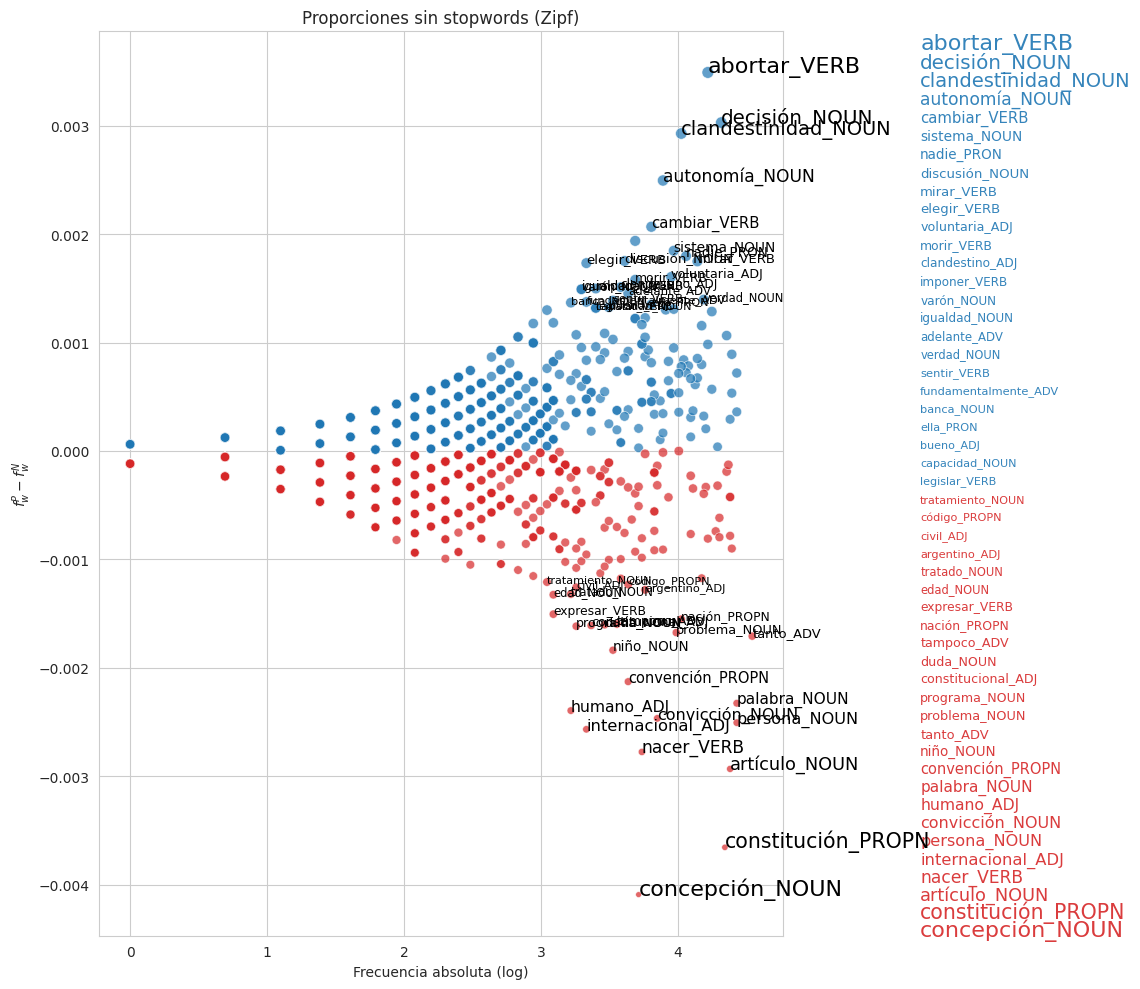

In [44]:
filename = "proporciones_sin_stopwords_zipf"
save_dataframe(proportions_wo_stw_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(
    proportions_wo_stw_diff, "Proporciones sin stopwords (Zipf)", "$f^{P}_{w}-f^{N}_{w}$", file
)

In [45]:
list_words(proportions_wo_stw_diff)

--- POS
`voluntaria', `clandestino', `bueno' (adj)
`adelante', `fundamentalmente' (adv)
`decisión', `clandestinidad', `autonomía', `sistema', `discusión', `varón', `igualdad', `verdad', `banca', `capacidad' (noun)
`nadie', `ella' (pron)
`abortar', `cambiar', `mirar', `elegir', `morir', `imponer', `sentir', `legislar' (verb)
--- NEG
`civil', `argentino', `constitucional', `humano', `internacional' (adj)
`tampoco', `tanto' (adv)
`tratamiento', `tratado', `edad', `duda', `programa', `problema', `niño', `palabra', `convicción', `persona', `artículo', `concepción' (noun)
`código', `nación', `convención', `constitución' (propn)
`expresar', `nacer' (verb)


## Ratio odds

$$
O_{w}^{i} = \frac{f_{w}^{i}}{(1-f_{w}^{i})}
$$

$$
\theta_{w}^{(P-N)} = \frac{O_{w}^{(P)}}{O_{w}^{(N)}}
$$

In [46]:
odds_pos = proportions.loc["positivo"]/(1-proportions.loc["positivo"])
odds_neg = proportions.loc["negativo"]/(1-proportions.loc["negativo"])
odds_difference = odds_pos/odds_neg
odds_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": odds_difference,
        "pos": odds_pos,
        "neg": odds_neg
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
odds_diff.head()

,word,total,diff,pos,neg
0,a_adp,7.4793,1.202876,0.027392,0.022772
1,abajo_adv,0.0000,0.000000,0.000000,0.000043
2,abandonada_adj,0.0000,inf,0.000021,0.000000
3,abandonado_adj,0.0000,inf,0.000021,0.000000
4,abandonar_verb,0.0000,0.000000,0.000000,0.000043


In [47]:
odds_diff["diff"].isin([math.inf]).sum(), odds_diff["diff"].isin([-math.inf]).sum()

(1756, 0)

In [48]:
odds_diff.shape

(4480, 5)

In [49]:
def postprocess_odds(row):
    infs = [math.inf, -math.inf]
    if (row.pos in infs) and (row.neg in infs):
        if row.pos == row.neg:
            return 1
        else:
            return -1
    else:
        return row["diff"]

In [50]:
# remove infs to avoid ploting inf values
odds_diff_not_inf = odds_diff[~odds_diff["diff"].isin([math.inf, -math.inf])]

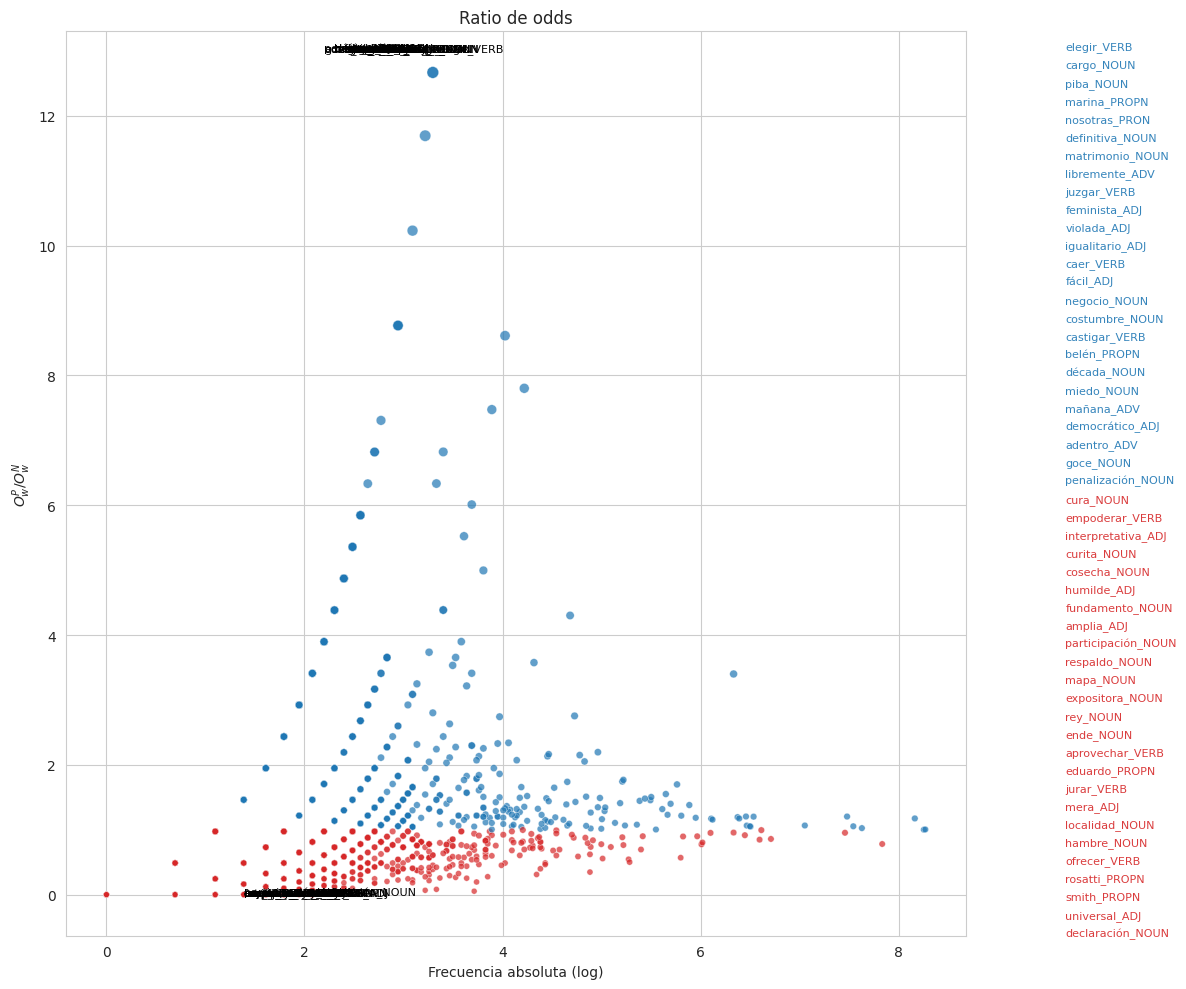

In [51]:
filename = "odds"
save_dataframe(odds_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(odds_diff, "Ratio de odds", "$O^{P}_{w}/O^{N}_{w}$", file, threshold=1)

In [52]:
list_words(odds_diff, threshold=1)

--- POS
`feminista', `violada', `igualitario', `fácil', `democrático' (adj)
`libremente', `mañana', `adentro' (adv)
`cargo', `piba', `definitiva', `matrimonio', `negocio', `costumbre', `década', `miedo', `goce', `penalización' (noun)
`nosotras' (pron)
`marina', `belén' (propn)
`elegir', `juzgar', `caer', `castigar' (verb)
--- NEG
`interpretativa', `humilde', `amplia', `mera', `universal' (adj)
`cura', `curita', `cosecha', `fundamento', `participación', `respaldo', `mapa', `expositora', `rey', `ende', `localidad', `hambre', `declaración' (noun)
`eduardo', `rosatti', `smith' (propn)
`empoderar', `aprovechar', `jurar', `ofrecer' (verb)


## Ratio de log-odds

El problema de los _odds_ es que, por su asimetría, son muy difíciles de interpretar. Tomar el logaritmo del ratio permite tener una medida simétrica entre ambas posturas de votantes.

$$
\log{\bigg(\frac{O_{w}^{(P)}}{O_{w}^{(N)}}\bigg)}
$$

El problema aquí reside en qué hacer con las palabras que solo son mencionadas por una de las posturas y que, entonces, conducen a _odds_ infinitos.

In [53]:
log_odds_diff = deepcopy(odds_diff)
log_odds_diff["diff"] = np.log(log_odds_diff["diff"])
log_odds_diff.head()

/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,word,total,diff,pos,neg
0,a_adp,7.4793,0.184716,0.027392,0.022772
1,abajo_adv,0.0000,-inf,0.000000,0.000043
2,abandonada_adj,0.0000,inf,0.000021,0.000000
3,abandonado_adj,0.0000,inf,0.000021,0.000000
4,abandonar_verb,0.0000,-inf,0.000000,0.000043


In [54]:
# palabras más representativas de quienes votaron a favor
(
    log_odds_diff
    .sort_values(by=["diff", "pos"], ascending=False, ignore_index=True)
    .head(20)
)

,word,total,diff,pos,neg
0,elegir_verb,3.332205,inf,0.000593,0.0
1,cargo_noun,3.044522,inf,0.000445,0.0
2,piba_noun,2.944439,inf,0.000403,0.0
3,marina_propn,2.833213,inf,0.000360,0.0
4,nosotras_pron,2.833213,inf,0.000360,0.0
5,afirmativo_adj,2.708050,inf,0.000318,0.0
6,definitiva_noun,2.708050,inf,0.000318,0.0
7,matrimonio_noun,2.708050,inf,0.000318,0.0
8,libremente_adv,2.639057,inf,0.000297,0.0
9,feminista_adj,2.484907,inf,0.000254,0.0


In [55]:
# palabras más representativas de quienes votaron a favor removiendo los =0
(
    log_odds_diff[(log_odds_diff.neg>0) & (log_odds_diff.pos>0)]
    .sort_values(by=["diff", "pos"], ascending=False, ignore_index=True)
    .head(20)
)

,word,total,diff,pos,neg
0,igualdad_noun,3.295837,2.539064,0.000551,0.000043
1,varón_noun,3.295837,2.539064,0.000551,0.000043
2,banca_noun,3.218876,2.458979,0.000508,0.000043
3,ampliación_noun,3.091042,2.325384,0.000445,0.000043
4,lucha_noun,2.944439,2.171170,0.000381,0.000043
5,maternidad_noun,2.944439,2.171170,0.000381,0.000043
6,religión_noun,2.944439,2.171170,0.000381,0.000043
7,clandestinidad_noun,4.025352,2.153133,0.001124,0.000130
8,abortar_verb,4.219508,2.054231,0.001357,0.000174
9,autonomía_noun,3.891820,2.011334,0.000975,0.000130


In [56]:
# palabras más representativas de quienes votaron en contra
(
    log_odds_diff
    .sort_values(by=["diff", "neg"], ascending=[True, False], ignore_index=True)
    .head(20)
)

,word,total,diff,pos,neg
0,declaración_noun,2.079442,-inf,0.0,0.000348
1,smith_propn,2.079442,-inf,0.0,0.000348
2,universal_adj,2.079442,-inf,0.0,0.000348
3,rosatti_propn,1.945910,-inf,0.0,0.000304
4,eduardo_propn,1.791759,-inf,0.0,0.000261
5,expresión_noun,1.791759,-inf,0.0,0.000261
6,hambre_noun,1.791759,-inf,0.0,0.000261
7,jurar_verb,1.791759,-inf,0.0,0.000261
8,localidad_noun,1.791759,-inf,0.0,0.000261
9,mera_adj,1.791759,-inf,0.0,0.000261


In [57]:
# palabras más representativas de quienes votaron en contra removiendo los =0
(
    log_odds_diff[(log_odds_diff.neg>0) & (log_odds_diff.pos>0)]
    .sort_values(by=["diff", "neg"], ascending=[True, False], ignore_index=True)
    .head(20)
)

,word,total,diff,pos,neg
0,concepción_noun,3.713572,-2.945689,0.000085,0.001612
1,mitad_noun,2.302585,-2.917134,0.000021,0.000392
2,humano_adj,3.218876,-2.712863,0.000064,0.000958
3,amplio_adj,2.079442,-2.665733,0.000021,0.000304
4,científico_adj,2.079442,-2.665733,0.000021,0.000304
5,honrar_verb,2.079442,-2.665733,0.000021,0.000304
6,mala_adj,2.079442,-2.665733,0.000021,0.000304
7,internacional_adj,3.332205,-2.512259,0.000085,0.001045
8,impacto_noun,1.945910,-2.511539,0.000021,0.000261
9,jerarquía_noun,1.945910,-2.511539,0.000021,0.000261


In [58]:
# remove infs to avoid ploting inf values
#log_odds_diff_not_inf = log_odds_diff[~log_odds_diff["diff"].isin([math.inf, -math.inf])]

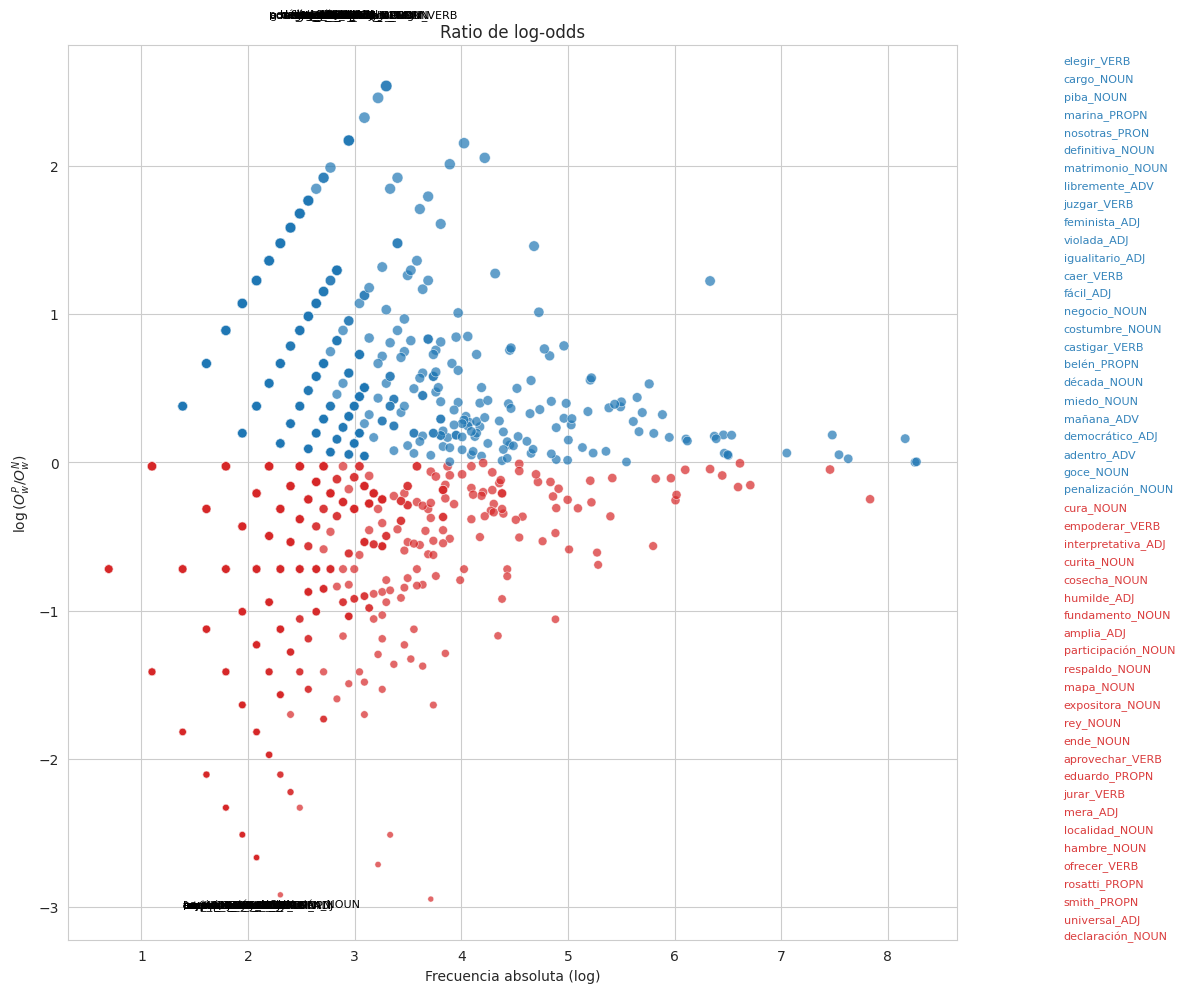

In [59]:
filename = "log_odds"
save_dataframe(log_odds_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(
    log_odds_diff, "Ratio de log-odds", "$\log{(O^{P}_{w}/O^{N}_{w})}$", file
)

In [60]:
list_words(log_odds_diff, )

--- POS
`feminista', `violada', `igualitario', `fácil', `democrático' (adj)
`libremente', `mañana', `adentro' (adv)
`cargo', `piba', `definitiva', `matrimonio', `negocio', `costumbre', `década', `miedo', `goce', `penalización' (noun)
`nosotras' (pron)
`marina', `belén' (propn)
`elegir', `juzgar', `caer', `castigar' (verb)
--- NEG
`interpretativa', `humilde', `amplia', `mera', `universal' (adj)
`cura', `curita', `cosecha', `fundamento', `participación', `respaldo', `mapa', `expositora', `rey', `ende', `localidad', `hambre', `declaración' (noun)
`eduardo', `rosatti', `smith' (propn)
`empoderar', `aprovechar', `jurar', `ofrecer' (verb)


## Log-odds ratio suvizado

Una opción para sobrellevar el problema de los _odds_ infinitos es agregar suavizado (por ejemplo: 0.5):
$$
\widetilde{f}^{(i)} = f^{(i)} + \varepsilon
$$

En este enfoque, el problema mayor es que las métricas se ven dominadas por los casos de palabras más oscuras o que aparecen menos.

In [61]:
smooth_log_odds_diff = deepcopy(proportions_diff[["word", "total", "pos", "neg"]])
smooth_log_odds_diff.head()

,word,total,pos,neg
0,a_adp,7.4793,0.026661,0.022265
1,abajo_adv,0.0000,0.000000,0.000043
2,abandonada_adj,0.0000,0.000021,0.000000
3,abandonado_adj,0.0000,0.000021,0.000000
4,abandonar_verb,0.0000,0.000000,0.000043


# cantidad de palabras con frecuencia 0
(smooth_log_odds_diff[["pos", "neg"]]==0).sum(axis=0)

In [63]:
smooth_log_odds_diff[["f_pos", "f_neg"]] = smooth_log_odds_diff[["pos", "neg"]].applymap(
    lambda x: x+0.5 if x == 0 else x
)
smooth_log_odds_diff.head()

,word,total,pos,neg,f_pos,f_neg
0,a_adp,7.4793,0.026661,0.022265,0.026661,0.022265
1,abajo_adv,0.0000,0.000000,0.000043,0.500000,0.000043
2,abandonada_adj,0.0000,0.000021,0.000000,0.000021,0.500000
3,abandonado_adj,0.0000,0.000021,0.000000,0.000021,0.500000
4,abandonar_verb,0.0000,0.000000,0.000043,0.500000,0.000043


In [64]:
(smooth_log_odds_diff[["f_pos", "f_neg"]]==0).sum(axis=0)

f_pos    0
f_neg    0
dtype: int64

In [65]:
f_smooth_odds_pos = smooth_log_odds_diff["f_pos"]/(1-smooth_log_odds_diff["f_pos"])
f_smooth_odds_neg = smooth_log_odds_diff["f_neg"]/(1-smooth_log_odds_diff["f_neg"])
f_smooth_odds_difference = f_smooth_odds_pos/f_smooth_odds_neg
f_smooth_log_odds_diff = (
    pd
    .DataFrame({
        "word": smooth_log_odds_diff.word,
        "total": smooth_log_odds_diff.total,
        "diff": np.log(f_smooth_odds_difference),
        "pos": f_smooth_odds_pos,
        "neg": f_smooth_odds_neg
    })
)
f_smooth_log_odds_diff.head()

,word,total,diff,pos,neg
0,a_adp,7.4793,0.184716,0.027392,0.027392
1,abajo_adv,0.0000,10.043032,1.000000,1.000000
2,abandonada_adj,0.0000,-10.762594,0.000021,0.000021
3,abandonado_adj,0.0000,-10.762594,0.000021,0.000021
4,abandonar_verb,0.0000,10.043032,1.000000,1.000000


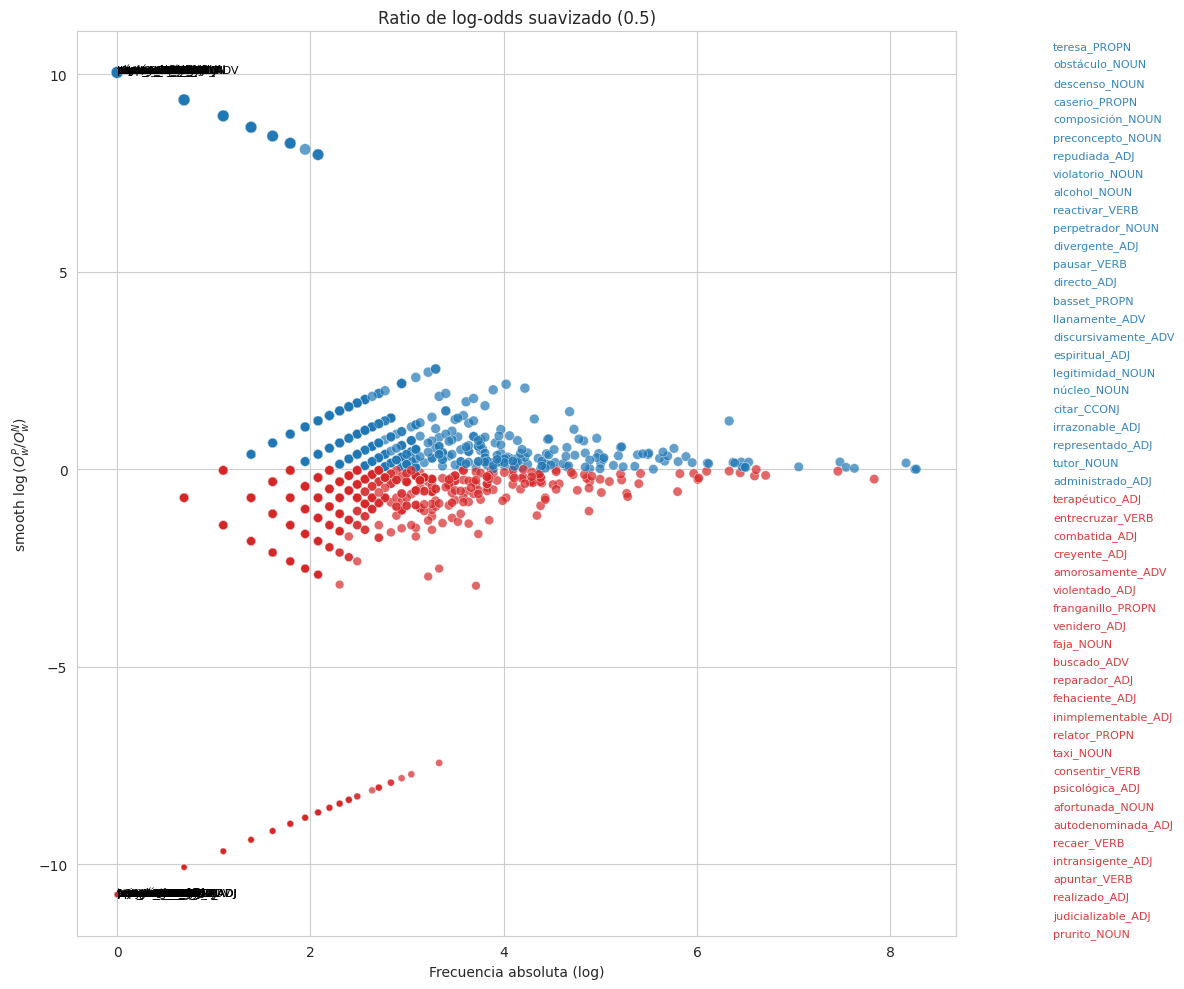

In [66]:
filename = "log_odds_suavizado"
save_dataframe(f_smooth_log_odds_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(
    f_smooth_log_odds_diff,
    "Ratio de log-odds suavizado (0.5)",
    "smooth $\log{(O^{P}_{w}/O^{N}_{w})}$",
    file
)

In [67]:
list_words(f_smooth_log_odds_diff)

--- POS
`repudiada', `divergente', `directo', `espiritual', `irrazonable', `representado', `administrado' (adj)
`llanamente', `discursivamente' (adv)
`citar' (cconj)
`obstáculo', `descenso', `composición', `preconcepto', `violatorio', `alcohol', `perpetrador', `legitimidad', `núcleo', `tutor' (noun)
`teresa', `caserio', `basset' (propn)
`reactivar', `pausar' (verb)
--- NEG
`terapéutico', `combatida', `creyente', `violentado', `venidero', `reparador', `fehaciente', `inimplementable', `psicológica', `autodenominada', `intransigente', `realizado', `judicializable' (adj)
`amorosamente', `buscado' (adv)
`faja', `taxi', `afortunada', `prurito' (noun)
`franganillo', `relator' (propn)
`entrecruzar', `consentir', `recaer', `apuntar' (verb)


## Ratio de log-odds sin palabras de baja frecuencia

Se define un umbral a partir del cual se considera que una palabra es frecuente y se consideran solo aquellas cuya frecuencia supera ese umbral.
Esto remueve los rasgos más problemáticos pero no resuelve el problema de fondo.

In [68]:
proportions_diff.total.describe().to_frame()

,total
count,4480.000000
mean,1.026541
std,1.288915
min,0.000000
25%,0.000000
50%,0.693147
75%,1.609438
max,8.269501


In [69]:
(
    pd.melt(
        proportions_diff[["word","total","pos","neg"]],
        id_vars=["word"],
        value_vars=["pos", "neg","total"],
    )
    .groupby("variable")["value"]
    .agg(
        min="min",
        q5=lambda x: np.percentile(x, q = 5),
        median="median",
        mean="mean",
        std="std",
        q95=lambda x: np.percentile(x, q = 95),
        max="max"
    )
)

,min,q5,median,mean,std,q95,max
variable,,,,,,,
neg,0.0,0.0,0.000043,0.000223,0.001798,0.000565,0.055444
pos,0.0,0.0,0.000021,0.000223,0.001830,0.000552,0.055652
total,0.0,0.0,0.693147,1.026541,1.288915,3.637586,8.269501


In [70]:
proportions_diff.shape

(4480, 5)

In [71]:
high_freq = (
    proportions_diff
    .loc[proportions_diff.total>1, ["word", "total", "pos", "neg"]]
    .reset_index(drop=True)
)
high_freq.shape

(1827, 4)

In [72]:
high_freq_perc = round(high_freq.shape[0]/proportions_diff.shape[0]*100,2)
print(
    f"Tras remover las palabras de baja frecuencia, nos quedamos con el {high_freq_perc}% de los datos"
)

Tras remover las palabras de baja frecuencia, nos quedamos con el 40.78% de los datos


In [73]:
# palabras removidas
proportions_diff[proportions_diff.total<=0.25].word.to_list()

['abajo_adv',
 'abandonada_adj',
 'abandonado_adj',
 'abandonar_verb',
 'abandono_noun',
 'abdominal_adj',
 'aber_verb',
 'aberración_noun',
 'aberrante_adj',
 'abiertamente_adv',
 'abierto_adj',
 'abismo_noun',
 'abocado_adj',
 'abogada_noun',
 'abogado_noun',
 'abolición_noun',
 'abortista_adj',
 'abortivo_adj',
 'abruptamente_adv',
 'absolución_noun',
 'absolver_verb',
 'abstención_noun',
 'abstracción_noun',
 'abstracto_adj',
 'abuelastro_noun',
 'abuelo_noun',
 'abultado_adj',
 'abusiva_adj',
 'acelerada_adj',
 'acelerar_verb',
 'acentuar_verb',
 'acoger_verb',
 'acomodar_verb',
 'acompañado_adj',
 'acompañante_noun',
 'acompañasar_verb',
 'aconsejar_verb',
 'acontecer_verb',
 'acordado_verb',
 'activismo_noun',
 'actor_noun',
 'adam_propn',
 'adecuado_adj',
 'adjetivación_noun',
 'adjetivar_adv',
 'adjetivar_verb',
 'adjudicar_verb',
 'administrado_adj',
 'administrativamente_adv',
 'admirar_verb',
 'admisible_adj',
 'adolfo_propn',
 'adoptada_adj',
 'adquisitivo_adj',
 'adscribi

In [74]:
(high_freq[["pos", "neg"]] == 0).sum()

pos     69
neg    288
dtype: int64

In [75]:
high_freq_odds_pos = high_freq["pos"]/(1-high_freq["pos"])
high_freq_odds_neg = high_freq["neg"]/(1-high_freq["neg"])
high_freq_odds_difference = high_freq_odds_pos/high_freq_odds_neg
high_freq_log_odds_diff = (
    pd
    .DataFrame({
        "word": high_freq.word,
        "total": high_freq.total,
        "diff": np.log(high_freq_odds_difference),
        "pos": high_freq_odds_pos,
        "neg": high_freq_odds_neg
    })
    .reset_index(drop=True)
)
high_freq_log_odds_diff.head()

/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,word,total,diff,pos,neg
0,a_adp,7.479300,0.184716,0.027392,0.022772
1,abogado_det,1.791759,-2.329174,0.000021,0.000217
2,abordaje_noun,1.609438,-2.105987,0.000021,0.000174
3,abordar_verb,1.791759,-0.026395,0.000085,0.000087
4,abortar_verb,4.219508,2.054231,0.001357,0.000174


In [76]:
# remove infs to avoid ploting inf values
high_freq_log_odds_diff_not_inf = high_freq_log_odds_diff[
    ~high_freq_log_odds_diff["diff"].isin([math.inf, -math.inf])
]

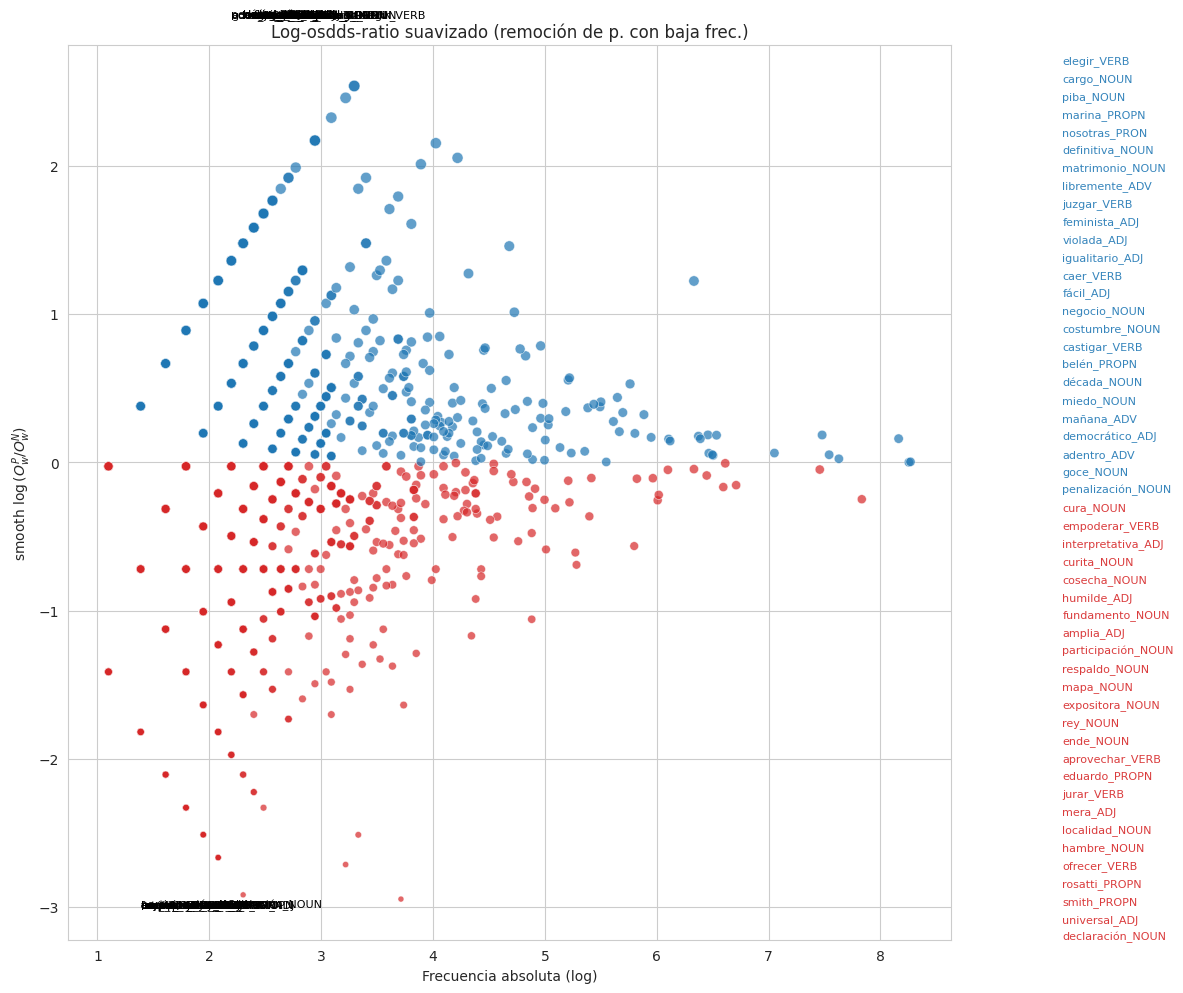

In [77]:
filename = "log_odds_sin_baja_freq"
save_dataframe(high_freq_log_odds_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(
    high_freq_log_odds_diff,
    "Log-osdds-ratio suavizado (remoción de p. con baja frec.)",
    "smooth $\log{(O^{P}_{w}/O^{N}_{w})}$",
    file
)

In [78]:
list_words(high_freq_log_odds_diff)

--- POS
`feminista', `violada', `igualitario', `fácil', `democrático' (adj)
`libremente', `mañana', `adentro' (adv)
`cargo', `piba', `definitiva', `matrimonio', `negocio', `costumbre', `década', `miedo', `goce', `penalización' (noun)
`nosotras' (pron)
`marina', `belén' (propn)
`elegir', `juzgar', `caer', `castigar' (verb)
--- NEG
`interpretativa', `humilde', `amplia', `mera', `universal' (adj)
`cura', `curita', `cosecha', `fundamento', `participación', `respaldo', `mapa', `expositora', `rey', `ende', `localidad', `hambre', `declaración' (noun)
`eduardo', `rosatti', `smith' (propn)
`empoderar', `aprovechar', `jurar', `ofrecer' (verb)


## TF-IDF

### Frecuencia de término natural, frecuencia de documento _logged_, no normalizado

$$
\text{tf.idf}_{w}^{(i)}(ntn) = f_{w}^{(i)}\ln{(1/df_{w})}
$$

$$
\text{tf.idf}_{w}^{(i)}(nnn) = f_{w}^{(i)}/df_{w}
$$

In [79]:
tf_idf = deepcopy(proportions_diff[["word", "total", "pos", "neg"]])
tf_idf.head()

,word,total,pos,neg
0,a_adp,7.4793,0.026661,0.022265
1,abajo_adv,0.0000,0.000000,0.000043
2,abandonada_adj,0.0000,0.000021,0.000000
3,abandonado_adj,0.0000,0.000021,0.000000
4,abandonar_verb,0.0000,0.000000,0.000043


In [80]:
vectorizer = CountVectorizer(lowercase=True, )
X = vectorizer.fit_transform(data.speech_lemma_pos)
X = X.toarray()
tf_idf = (
    pd.DataFrame(
        X, columns=vectorizer.get_feature_names_out()
    )
    .sum(axis=0)
    .to_frame("df")
    .reset_index(names="word")
    .merge(
        tf_idf, on="word", how="right"
    )
    [["word", "total", "pos", "neg", "df"]]
)
tf_idf.head()


,word,total,pos,neg,df
0,a_adp,7.4793,0.026661,0.022265,1771
1,abajo_adv,0.0000,0.000000,0.000043,1
2,abandonada_adj,0.0000,0.000021,0.000000,1
3,abandonado_adj,0.0000,0.000021,0.000000,1
4,abandonar_verb,0.0000,0.000000,0.000043,1


In [81]:
tf_idf["idf"] = tf_idf.df.apply(lambda x: 1/x)
tf_idf.head()

,word,total,pos,neg,df,idf
0,a_adp,7.4793,0.026661,0.022265,1771,0.000565
1,abajo_adv,0.0000,0.000000,0.000043,1,1.000000
2,abandonada_adj,0.0000,0.000021,0.000000,1,1.000000
3,abandonado_adj,0.0000,0.000021,0.000000,1,1.000000
4,abandonar_verb,0.0000,0.000000,0.000043,1,1.000000


In [82]:
tf_idf["log_idf"] = tf_idf.idf.apply(lambda x: math.log(x))
tf_idf.head()

,word,total,pos,neg,df,idf,log_idf
0,a_adp,7.4793,0.026661,0.022265,1771,0.000565,-7.4793
1,abajo_adv,0.0000,0.000000,0.000043,1,1.000000,0.0000
2,abandonada_adj,0.0000,0.000021,0.000000,1,1.000000,0.0000
3,abandonado_adj,0.0000,0.000021,0.000000,1,1.000000,0.0000
4,abandonar_verb,0.0000,0.000000,0.000043,1,1.000000,0.0000


In [83]:
tfidf_ntn = (
    tf_idf
    .assign(
        pos=tf_idf.apply(lambda x: x.pos*x.log_idf, axis=1),
        neg=tf_idf.apply(lambda x: x.neg*x.log_idf, axis=1)
    )
    .assign(diff=lambda x: x.pos - x.neg)
    [["word", "total", "pos", "neg", "diff"]]
)
tfidf_ntn.head()

,word,total,pos,neg,diff
0,a_adp,7.4793,-0.199408,-0.166525,-0.032883
1,abajo_adv,0.0000,0.000000,0.000000,0.000000
2,abandonada_adj,0.0000,0.000000,0.000000,0.000000
3,abandonado_adj,0.0000,0.000000,0.000000,0.000000
4,abandonar_verb,0.0000,0.000000,0.000000,0.000000


In [84]:
corr_prop = tfidf_ntn["diff"].corr(proportions_diff["diff"])
print(f"Correlación con proporciones: {round(corr_prop,2)}")

Correlación con proporciones: -0.96


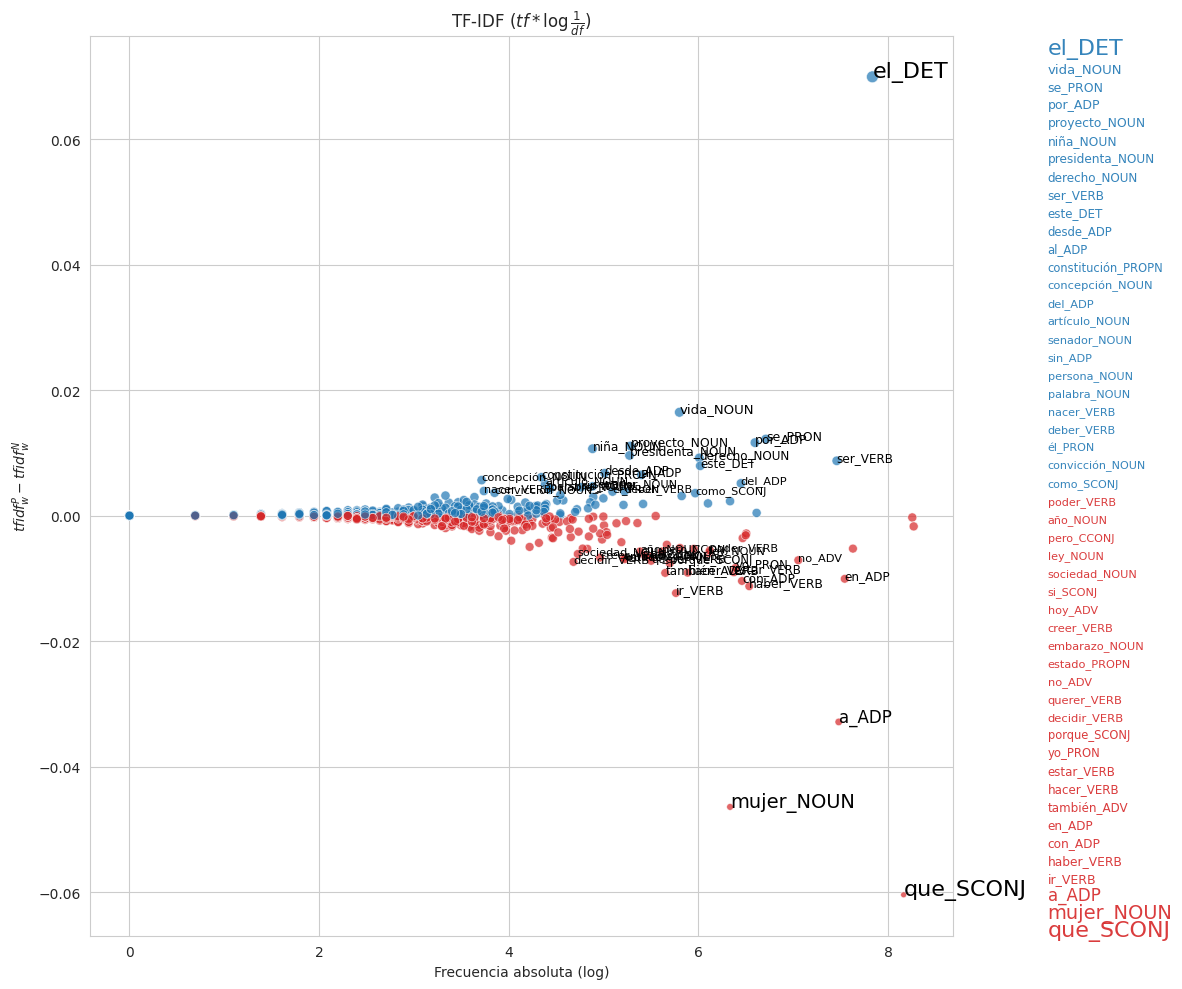

In [85]:
filename = "tfidf_dflogged"
save_dataframe(tfidf_ntn, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(
    tfidf_ntn,
    r"TF-IDF $(tf*\log\frac{1}{df})$",
    "$tfidf^{P}_{w}-tfidf^{N}_{w}$",
    file
)

In [86]:
list_words(proportions_diff)

--- POS
`a', `con', `en' (adp)
`también', `hoy' (adv)
`pero' (cconj)
`mujer', `sociedad', `embarazo', `debate', `año' (noun)
`yo' (pron)
`estado' (propn)
`que', `porque', `si' (sconj)
`ir', `haber', `decidir', `hacer', `estar', `creer', `querer', `abortar', `seguir' (verb)
--- NEG
`humano', `internacional' (adj)
`del', `sin', `al', `desde', `por' (adp)
`este', `el' (det)
`palabra', `convicción', `senador', `persona', `artículo', `concepción', `derecho', `presidenta', `proyecto', `niña', `vida' (noun)
`se' (pron)
`convención', `constitución' (propn)
`nacer', `ser' (verb)


In [87]:
list_words(tfidf_ntn.assign(diff=lambda x: -x["diff"]))

--- POS
`a', `con', `en' (adp)
`también', `no', `hoy' (adv)
`pero' (cconj)
`mujer', `embarazo', `sociedad', `ley', `año' (noun)
`yo' (pron)
`estado' (propn)
`que', `porque', `si' (sconj)
`ir', `haber', `hacer', `estar', `decidir', `querer', `creer', `poder' (verb)
--- NEG
`sin', `del', `al', `desde', `por' (adp)
`este', `el' (det)
`convicción', `palabra', `persona', `senador', `artículo', `concepción', `derecho', `presidenta', `niña', `proyecto', `vida' (noun)
`él', `se' (pron)
`constitución' (propn)
`como' (sconj)
`deber', `nacer', `ser' (verb)


### Frecuencia de término natural, frecuencia de documento natural, no normalizado

In [88]:
tfidf_nnn = (
    tf_idf
    .assign(
        pos=tf_idf.apply(lambda x: x.pos/x.df, axis=1),
        neg=tf_idf.apply(lambda x: x.neg/x.df, axis=1)
    )
    .assign(diff=lambda x: x.pos - x.neg)
    [["word", "total", "pos", "neg", "diff"]]
)
tfidf_nnn.head()

,word,total,pos,neg,diff
0,a_adp,7.4793,0.000015,0.000013,0.000002
1,abajo_adv,0.0000,0.000000,0.000043,-0.000043
2,abandonada_adj,0.0000,0.000021,0.000000,0.000021
3,abandonado_adj,0.0000,0.000021,0.000000,0.000021
4,abandonar_verb,0.0000,0.000000,0.000043,-0.000043


In [89]:
tf_idf[tf_idf.word.isin(["mujer_noun", "constitución_propn"])]

,word,total,pos,neg,df,idf,log_idf
901,constitución_propn,4.343805,0.000635,0.002044,77,0.012987,-4.343805
2801,mujer_noun,6.333280,0.010419,0.003087,563,0.001776,-6.333280


In [90]:
corr_prop = tfidf_nnn["diff"].corr(proportions_diff["diff"])
print(f"Correlación con proporciones: {round(corr_prop,2)}")

Correlación con proporciones: 0.21


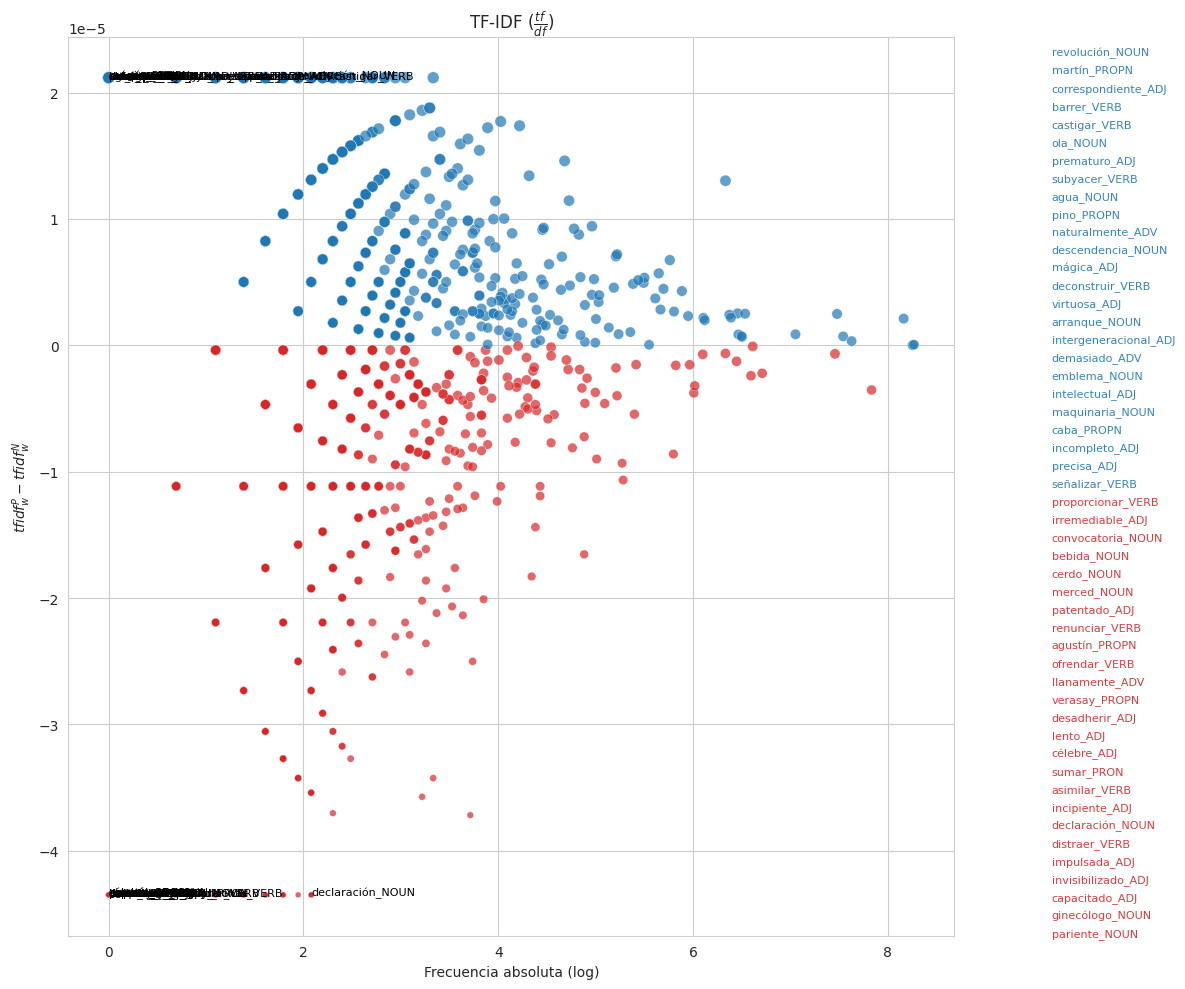

In [91]:
filename = "tfidf_dfnatural"
save_dataframe(tfidf_nnn, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(
    tfidf_nnn,
    r"TF-IDF ($\frac{tf}{df}$)",
    "$tfidf^{P}_{w}-tfidf^{N}_{w}$",
    file
)

## WordScores

$$
W_{w}^{{*}^{(P-N)}} = \frac{y_{w}^{(P)}/n^{(P)}-y_{w}^{(N)}/n^{(N)}}{y_{w}^{(P)}/n^{(P)}+y_{w}^{(N)}/n^{(N)}}n_{w}
$$

In [92]:
wkw = (
    (proportions.loc["positivo"]-proportions.loc["negativo"])/
    (proportions.loc["positivo"]+proportions.loc["negativo"])
)
nkw = frequencies.sum(axis=0)

wkw_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": wkw*nkw,
        "pos": wkw*nkw,
        "neg": wkw*nkw,
        "wkw": wkw,
        "nkw": nkw,
        "wnkw": wkw*nkw
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
wkw_diff.head()

,word,total,diff,pos,neg,wkw,nkw,wnkw
0,a_adp,7.4793,159.144448,159.144448,159.144448,0.089861,1771,159.144448
1,abajo_adv,0.0000,-1.000000,-1.000000,-1.000000,-1.000000,1,-1.000000
2,abandonada_adj,0.0000,1.000000,1.000000,1.000000,1.000000,1,1.000000
3,abandonado_adj,0.0000,1.000000,1.000000,1.000000,1.000000,1,1.000000
4,abandonar_verb,0.0000,-1.000000,-1.000000,-1.000000,-1.000000,1,-1.000000


In [93]:
corr_prop = wkw_diff["diff"].corr(proportions_diff["diff"])
print(f"Correlación con proporciones: {round(corr_prop,2)}")

Correlación con proporciones: 0.99


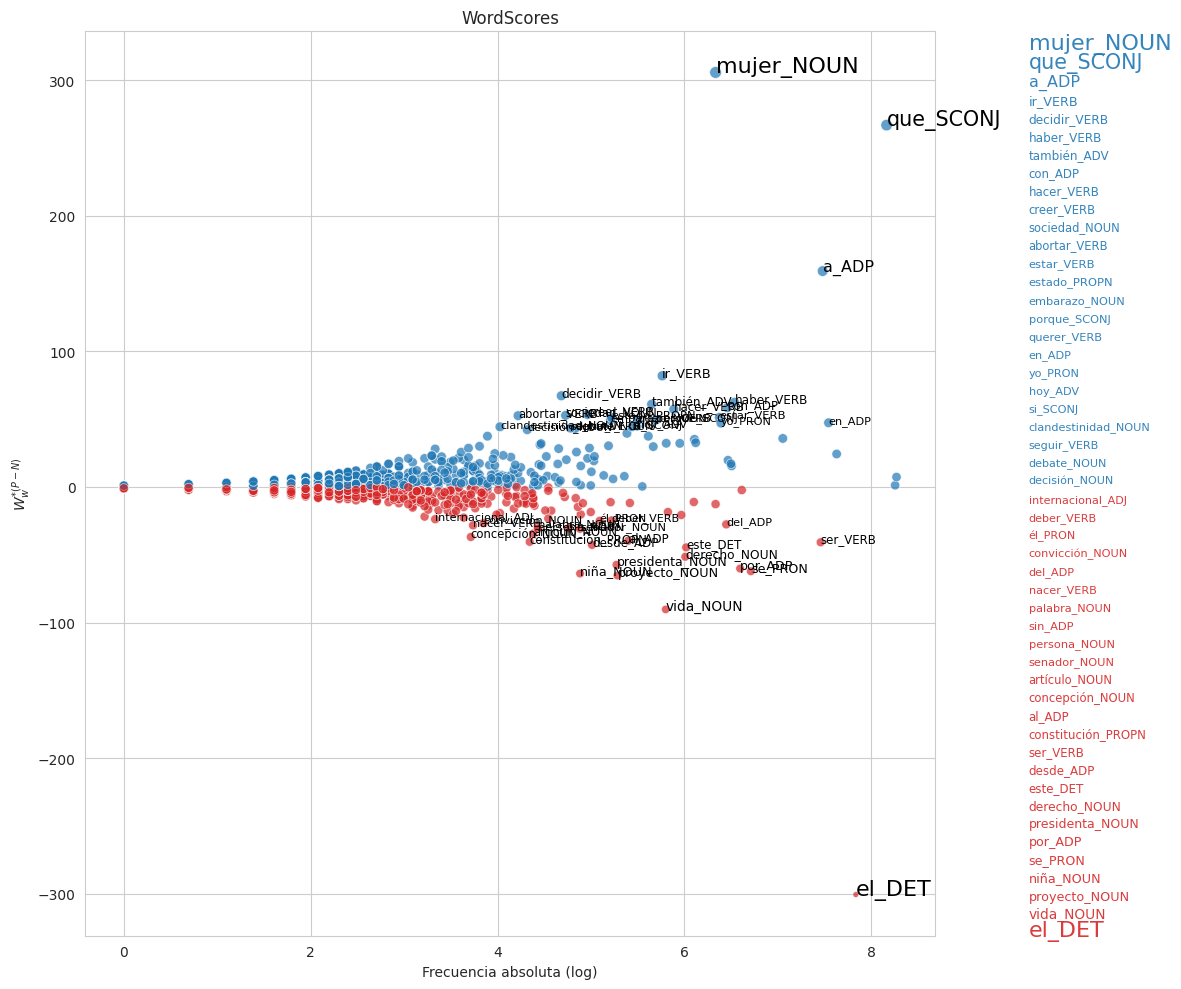

In [94]:
filename = "wordscores"
save_dataframe(wkw_diff, FOLDER, filename, latex=False)
file = os.path.join(FOLDER, f"{filename}.png")
plot_stats(
    wkw_diff,
    "WordScores",
    "$W^{*(P-N)}_{w}$",
    file
)

In [95]:
list_words(wkw_diff)

--- POS
`a', `con', `en' (adp)
`también', `hoy' (adv)
`mujer', `sociedad', `embarazo', `clandestinidad', `debate', `decisión' (noun)
`yo' (pron)
`estado' (propn)
`que', `porque', `si' (sconj)
`ir', `decidir', `haber', `hacer', `creer', `abortar', `estar', `querer', `seguir' (verb)
--- NEG
`internacional' (adj)
`del', `sin', `al', `desde', `por' (adp)
`este', `el' (det)
`convicción', `palabra', `persona', `senador', `artículo', `concepción', `derecho', `presidenta', `niña', `proyecto', `vida' (noun)
`él', `se' (pron)
`constitución' (propn)
`deber', `nacer', `ser' (verb)
